In [1]:
import pandas as pd
import numpy as np
from string import punctuation
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import re
import os
from rapidfuzz import fuzz, process

In [2]:
bus_df = pd.read_csv('ttc-bus-delay-data-2024.csv')
stops_df = pd.read_csv('stops_cleaned.csv')

In [3]:
bus_df.columns = [s.strip().replace(' ','_') for s in bus_df.columns]

### Adding new neccesary columns

In [4]:
bus_df.loc[:,'TransportType'] = 'Bus'
bus_df = bus_df.drop(columns = ['Min_Gap'])

In [5]:
bus_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45300 entries, 0 to 45299
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Date           45300 non-null  object
 1   Route          44861 non-null  object
 2   Time           45300 non-null  object
 3   Day            45300 non-null  object
 4   Location       45300 non-null  object
 5   Incident       45300 non-null  object
 6   Min_Delay      45300 non-null  int64 
 7   Direction      38343 non-null  object
 8   Vehicle        45300 non-null  int64 
 9   TransportType  45300 non-null  object
dtypes: int64(2), object(8)
memory usage: 3.5+ MB


In [6]:
bus_df.nunique()

Date              274
Route             256
Time             1440
Day                 7
Location         8889
Incident           12
Min_Delay         496
Direction          12
Vehicle          2353
TransportType       1
dtype: int64

### 1.1 Missing Values

In [7]:
bus_df.isnull().sum()

Date                0
Route             439
Time                0
Day                 0
Location            0
Incident            0
Min_Delay           0
Direction        6957
Vehicle             0
TransportType       0
dtype: int64

### 1.2 Date and Time Formatting 

In [8]:
# Function to split the date
def split_date(date_str):
    # Convert the date string to a datetime object
    # Check if date is in 1-Jan-24 format
    if re.match(r"\d{1,2}-[A-Za-z]{3,4}-\d{2}", date_str):
        date_obj = pd.to_datetime(date_str, format='%d-%b-%y')
    # Check if date is in 2024-01-01 format
    elif re.match(r"\d{4}-\d{2}-\d{2}", date_str):
        date_obj = pd.to_datetime(date_str, format='%Y-%m-%d')
    else:
        raise ValueError(f"Unknown date format: {date_str}")

    # Extract day, month, and year
    day = date_obj.day
    month = date_obj.month
    year = date_obj.year

    # Standardize to DD-MM-YYYY
    return datetime(year, month, day).strftime("%d-%m-%Y")

In [9]:
bus_df.loc[:, 'Date'] = bus_df.loc[:,'Date'].apply(split_date)

### 1.3 Delays

In [10]:
# on time is 0 mins delays
# short delay is 1 to 15 mins.
# medium delay is 15 to 30 mins.
# long delay is more than 30 mins.
def delay_type(col):
    if col == 0 :
        return 'on-time'
    elif col >= 1 and col <= 15:
        return 'short'
    elif col > 15 and col <= 30:
        return 'medium'
    elif col > 30:
        return 'long'

# apply delay_type function
bus_df['delay_type'] = bus_df['Min_Delay'].apply(delay_type)

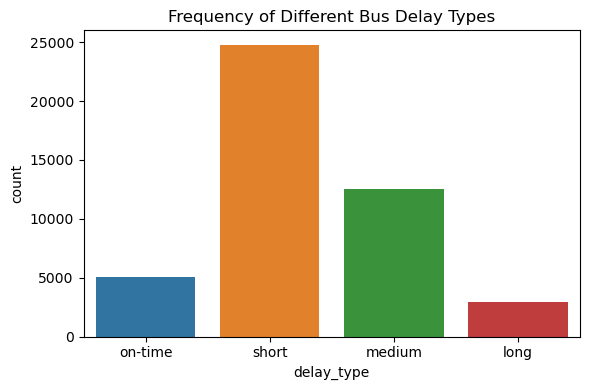

In [11]:
datasets = [bus_df]
titles = ['Bus Delay Types']
delay_type_order = ['on-time', 'short', 'medium', 'long']

# Loop through each dataset and create a separate plot
for i, df in enumerate(datasets):
    plt.figure(figsize=(6, 4))
    sns.countplot(x='delay_type', data=df, order=delay_type_order)
    plt.title(f'Frequency of Different {titles[i]}')
    plt.tight_layout()
    plt.show()

### 1.4 Filtering out Irrelevent Directions

In [12]:
# function to simplify direction in to N,S,E,W,B and NaN.
def direction_filter(direction):
    # convert all lowercase characters to uppercase, replace punctuations with empty space and remove leading and the trailing spaces.
    direction = str(direction).upper().replace(rf'[{punctuation}]', '').strip()
    if 'N' in direction:
        return 'N'
    elif 'S' in direction:
        return 'S'
    elif 'E' in direction:
        return 'E'
    elif 'W' in direction:
        return 'W'
    elif 'B' in direction:
        return 'B'
    else:
        'NaN'

bus_df['Direction'] = bus_df['Direction'].apply(direction_filter)

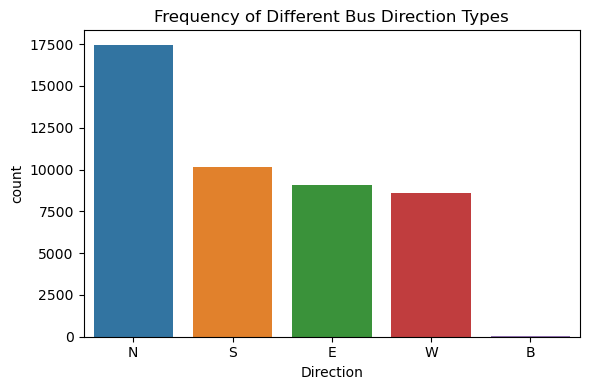

In [13]:
datasets = [bus_df]
titles = ['Bus Direction Types']
Direction_order = ['N', 'S', 'E', 'W', 'B']

for i, df in enumerate(datasets):
    plt.figure(figsize=(6, 4))
    sns.countplot(x='Direction', data=df, order=Direction_order)
    plt.title(f'Frequency of Different {titles[i]}')
    plt.tight_layout()
    plt.show()

In [14]:
bus_df = bus_df.dropna(subset = ['Route', 'Direction'])

In [15]:
bus_df.isnull().sum()

Date             0
Route            0
Time             0
Day              0
Location         0
Incident         0
Min_Delay        0
Direction        0
Vehicle          0
TransportType    0
delay_type       0
dtype: int64

### Joining columns of stops.csv & bus data

In [16]:
stops_df = stops_df.drop(columns=['stop_id', 'stop_code', 'stop_desc', 'zone_id', 'stop_url', 'location_type', 'parent_station', 'stop_timezone'])
stops_df['Latitude'] = stops_df['stop_lat']
stops_df['Longtitude'] = stops_df['stop_lon']

### Normalizing text in both datasets

In [17]:
#from rapidfuzz import fuzz, process

# Function to normalize text (expand abbreviations and remove unnecessary words)
def normalize_text(text):
    text = text.lower()
    text = text.replace(' st ', ' ')
    text = text.replace(' ave ', ' ')
    text = text.replace(' avenue ', ' ')
    text = text.replace(' street ', ' ')
    text = text.replace(' at ', ' ')
    text = text.replace(' and ', ' ')
    text = text.replace(' side ', ' ')
    text = text.replace(' hwy ', ' highway ')    
    text = text.replace(' east ', ' ')
    text = text.replace(' west ', ' ')
    text = text.replace(' north ', ' ')
    text = text.replace(' south ', ' ')
    return text.strip()

# Normalize the relevant columns
bus_df.loc[:, 'Normalized_Location'] = bus_df.loc[:, 'Location'].apply(normalize_text)
stops_df.loc[:, 'Normalized_stop_name'] = stops_df.loc[:, 'stop_name'].apply(normalize_text)

C:\Users\Jugal Patel\AppData\Local\Temp\ipykernel_31364\824950751.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bus_df.loc[:, 'Normalized_Location'] = bus_df.loc[:, 'Location'].apply(normalize_text)


### Using fuzzy matching

In [18]:
# Perform fuzzy matching for unmatched records
def fuzzy_match(location, stop_names, threshold=80):
    match = process.extractOne(location, stop_names, scorer=fuzz.token_set_ratio)
    if match and match[1] >= threshold:
        return match[0]  # Return the best match if similarity exceeds the threshold
    return None

In [19]:
# Create a list of normalized stop names for matching
normalized_stop_names = stops_df['Normalized_stop_name'].tolist()

# Apply fuzzy matching
bus_df.loc[:, 'Fuzzy_stop_name'] = bus_df.loc[:, 'Normalized_Location'].apply(
    lambda x: fuzzy_match(x, normalized_stop_names)
)

C:\Users\Jugal Patel\AppData\Local\Temp\ipykernel_31364\575618840.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bus_df.loc[:, 'Fuzzy_stop_name'] = bus_df.loc[:, 'Normalized_Location'].apply(


In [20]:
# Select required columns from bus_df and stops_df
bus_columns = ['Date', 'TransportType', 'Route', 'Time', 'Day', 'Location', 'Incident', 'Min_Delay', 'Direction', 'Vehicle', 'delay_type', 'Fuzzy_stop_name']
stops_columns = ['Latitude', 'Longtitude', 'wheelchair_boarding']

# Merge the datasets while retaining all records from bus_df and matched stop details
merged_data_fuzzy = pd.merge(
    bus_df[bus_columns],
    stops_df[stops_columns + ['Normalized_stop_name']],
    left_on='Fuzzy_stop_name',
    right_on='Normalized_stop_name',
    how='left'
)

In [21]:
# Check unmatched records
unmatched_fuzzy_records = merged_data_fuzzy[merged_data_fuzzy['Normalized_stop_name'].isna()]
unmatched_fuzzy_count = unmatched_fuzzy_records.shape[0]

In [22]:
unmatched_fuzzy_count

3589

In [23]:
# Drop 'Normalized_stop_name' & 'Fuzzy_stop_name' since it's not required in the final output
merged_data_fuzzy.drop(columns=['Normalized_stop_name', 'Fuzzy_stop_name'], inplace=True)

In [24]:
# Filter out unmatched records
cleaned_bus_df = merged_data_fuzzy[~merged_data_fuzzy['Latitude'].isna()]

# Save the cleaned dataset
cleaned_bus_df.to_csv('C:\\Users\\Jugal Patel\\Desktop\\Capstone project\\Data_cleaning\\Merged_bus.csv', index=False)

print(f"Cleaned bus dataset saved with {cleaned_bus_df.shape[0]} records.")

Cleaned bus dataset saved with 44684 records.


In [25]:
merged_data_fuzzy.head()

,Date,TransportType,Route,Time,Day,Location,Incident,Min_Delay,Direction,Vehicle,delay_type,Latitude,Longtitude,wheelchair_boarding
0,01-01-2024,Bus,89,02:08,Monday,KEELE AND GLENLAKE,Vision,10,N,7107,short,43.658499,-79.461695,1.0
1,01-01-2024,Bus,39,02:30,Monday,FINCH STATION,General Delay,20,N,8914,medium,43.764093,-79.490996,1.0
2,01-01-2024,Bus,39,02:30,Monday,FINCH STATION,General Delay,20,N,8914,medium,43.763952,-79.491402,1.0
3,01-01-2024,Bus,300,03:13,Monday,BLOOR AND MANNING,General Delay,0,N,8562,on-time,43.664160,-79.415911,1.0
4,01-01-2024,Bus,65,03:23,Monday,PARLIAMENT AND BLOOR,Security,0,N,8574,on-time,43.672194,-79.370653,2.0
